In [ ]:
# !pip uninstall tensorflow
# !pip install --upgrade tensorflow-gpu

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [ ]:
# Data directory
DATADIR = f'/content/drive/My Drive/LSTM_HUMAN/Human_Activity_Recognition/HAR/UCI_HAR_Dataset'
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [ ]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/LSTM_HUMAN/Human_Activity_Recognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/LSTM_HUMAN/Human_Activity_Recognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).values
    
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
import keras as keras
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [ ]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(n_classes)
print(len(X_train))

128
9
6
7352


## Hyper parameter Tuning

In [ ]:
X_train.shape

(7352, 128, 9)

In [ ]:
.

In [ ]:
def LSTM_Dropout(epochs,n_hidden,drop_rate,X_train,Y_train,X_test, Y_test,timesteps, input_dim):
    # Initiliazing the sequential model
    n_classes=6
    model = Sequential()
    # Configuring the parameters
    # Adding a dropout layer
    model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
    model.add(LSTM(100,input_shape=(timesteps, input_dim)))
    model.add(Dropout(drop_rate))
    # Adding a dense output layer with relu activation
    model.add(Dense(n_classes, activation='relu'))
    model.summary()
    # Compiling the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer="adam",
                  metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=16,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    print(confusion_matrix(Y_test, model.predict(X_test)))
    score = model.evaluate(X_test, Y_test)
    print("[Loss,Score]:{}".format(score))

In [ ]:
LSTM_Dropout(50,250,0.0,X_train,Y_train,X_test, Y_test,timesteps, input_dim)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 250)          260000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               140400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 401,006
Trainable params: 401,006
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/50




7352/7352 [==============================] - 213s 29ms/step - loss: 6.6714 - acc: 0

# Hidden layers and Drop outs

## More than 32 hidden layer units

- Defining the Architecture of LSTM

In [ ]:

def LSTM_Dropout(epochs,n_hidden,drop_rate,X_train,Y_train,X_test, Y_test,timesteps, input_dim):
    # Initiliazing the sequential model
    n_classes=6
    model = Sequential()
    # Configuring the parameters
    # Adding a dropout layer
    model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
    model.add(Dropout(drop_rate))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='relu',kernel_initializer=keras.initializers.glorot_normal(seed=None)))
    model.summary()
    # Compiling the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer="rmsprop",
                  metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=16,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    
    return model

In [ ]:
def confusion_mat(model,X_test,Y_test):
  print(confusion_matrix(Y_test, model.predict(X_test)))
  score = model.evaluate(X_test, Y_test)
  print("[Loss,Score]:{}".format(score))

In [ ]:
model=LSTM_Dropout(20,64,0.5,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/20




7352/7352 [==============================] - 115s 16ms/step - loss: 1.6524 - acc: 0.4981 - val_loss: 1.6375 - val_acc: 0.6267
Epoch 2/20
7352/7352 [==============================] - 107s 15ms/step - loss: 1.1762 - acc: 0

In [ ]:
confusion_mat(model,X_test,Y_test)

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  1      369  ...                   0                24
STANDING                 0       65  ...                   0                 8
WALKING                  0        0  ...                   8                59
WALKING_DOWNSTAIRS       0        0  ...                 406                10
WALKING_UPSTAIRS         0        0  ...                  11               438

[6 rows x 6 columns]
2947/2947 [==============================] - 7s 2ms/step
[Loss,Score]:[1.3316348139860328, 0.8856464200882254]


## With 100 Layers

In [ ]:
model=LSTM_Dropout(20,100,0.5,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               44000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total params: 44,606
Trainable params: 44,606
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 45s 6ms/step - loss: 1.2076 - acc: 0.4580 - val_loss: 1.1040 - val_acc: 0.5161
Epoch 2/20
7352/7352 [==============================] - 44s 6ms/step - loss: 0.8808 - acc: 0.6072 - val_loss: 0.8704 - val_acc: 0.6006
Epoch 3/20
7352/7352 [==============================] - 44s 6ms/step - loss: 0.7786 

## With 128 Layers 

In [ ]:
model=LSTM_Dropout(20,128,0.5,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 56s 8ms/step - loss: 1.2765 - acc: 0.4480 - val_loss: 1.2189 - val_acc: 0.5049
Epoch 2/20
7352/7352 [==============================] - 54s 7ms/step - loss: 1.0955 - acc: 0.5215 - val_loss: 1.3230 - val_acc: 0.3478
Epoch 3/20
7352/7352 [==============================] - 54s 7ms/step - loss: 0.8291 

## 150 Hidden Layers With 0.5 Dropout Rate

In [ ]:
model=LSTM_Dropout(20,150,0.5,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 150)               96000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 906       
Total params: 96,906
Trainable params: 96,906
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 66s 9ms/step - loss: 1.2182 - acc: 0.4713 - val_loss: 1.3923 - val_acc: 0.4245
Epoch 2/20
7352/7352 [==============================] - 64s 9ms/step - loss: 0.9698 - acc: 0.5745 - val_loss: 0.9378 - val_acc: 0.5959
Epoch 3/20
7352/7352 [==============================] - 65s 9ms/step - loss: 0.7785 

- With a simple 2 layer architecture and 64 lstm units we got 92.16% accuracy and a loss of 0.31
- We can further imporve the performace with Hyperparameter tuning

## LSTM Training With More Dropout Rate

In [ ]:
model=LSTM_Dropout(20,128,0.6,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix
confusion_mat(model,X_test,Y_test)

W0821 11:04:12.000723 140309728667520 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 55s 7ms/step - loss: 1.2296 - acc: 0.4611 - val_loss: 1.4506 - val_acc: 0.4320
Epoch 2/20
7352/7352 [==============================] - 53s 7ms/step - loss: 1.1184 - acc: 0.5131 - val_loss: 1.2153 - val_acc: 0.4781
Epoch 3/20
7352/7352 [==============================] - 53s 7ms/step - loss: 0.9210 

In [ ]:
model=LSTM_Dropout(20,128,0.7,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix
confusion_mat(model,X_test,Y_test)

W0827 08:27:38.339368 139928820402048 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 128s 17ms/step - loss: 1.2498 - acc: 0.4619 - val_loss: 1.3963 - val_acc: 0.4309
Epoch 2/20
7352/7352 [==============================] - 127s 17ms/step - loss: 0.9851 - acc: 0.5596 - val_loss: 0.8483 - val_acc: 0.6121
Epoch 3/20
7352/7352 [==============================] - 127s 17ms/step - loss: 0

In [ ]:
model=LSTM_Dropout(15,128,0.8,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix
confusion_mat(model,X_test,Y_test)

W0821 12:52:54.305728 140309728667520 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 55s 7ms/step - loss: 1.3914 - acc: 0.3987 - val_loss: 1.2605 - val_acc: 0.4082
Epoch 2/15
7352/7352 [==============================] - 52s 7ms/step - loss: 1.0895 - acc: 0.5214 - val_loss: 0.9742 - val_acc: 0.5738
Epoch 3/15
7352/7352 [==============================] - 51s 7ms/step - loss: 0.9079 

In [ ]:
model=LSTM_Dropout(20,128,0.4,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
# Confusion Matrix
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 54s 7ms/step - loss: 1.2076 - acc: 0.4694 - val_loss: 1.4387 - val_acc: 0.3848
Epoch 2/20
7352/7352 [==============================] - 51s 7ms/step - loss: 0.9906 - acc: 0.5541 - val_loss: 0.9297 - val_acc: 0.6732
Epoch 3/20
7352/7352 [==============================] - 50s 7ms/step - loss: 0.7084 

- With a simple one LSTM layer architecture and 64 lstm units we got 86.35% accuracy and a loss of 0.78

## Two Layer LSTM Without Dropout 128 layers

In [ ]:
def LSTM_Dropout(epochs,n_hidden,X_train,Y_train,X_test, Y_test,timesteps, input_dim):
    # Initiliazing the sequential model
    n_classes=6
    model = Sequential()
    # Configuring the parameters
    # Adding a dropout layer
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
    model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid',kernel_initializer=keras.initializers.glorot_normal(seed=None),bias_initializer=keras.initializers.Ones()))
    model.summary()
    # Compiling the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=16,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    return model

def confusion_mat(model,X_test,Y_test):
  print(confusion_matrix(Y_test, model.predict(X_test)))
  score = model.evaluate(X_test, Y_test)
  print("[Loss,Score]:{}".format(score))

In [ ]:
model=LSTM_Dropout(20,128,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 774       
Total params: 203,014
Trainable params: 203,014
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 129s 17ms/step - loss: 0.9495 - acc: 0.5842 - val_loss: 0.7855 - val_acc: 0.6590
Epoch 2/20
7352/7352 [==============================] - 124s 17ms/step - loss: 0.5942 - acc: 0.7601 - val_loss: 0.7787 - val_acc: 0.7197
Epoch 3/20
7352/7352 [==============================] - 124s 17ms/step - loss:

## Two Layer LSTM With Dropout(0.7) and 128 layers

In [ ]:
def LSTM_Dropout(epochs,n_hidden,Drop,X_train,Y_train,X_test, Y_test,timesteps, input_dim):
    # Initiliazing the sequential model
    n_classes=6
    model = Sequential()
    # Configuring the parameters
    # Adding a dropout layer
    model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
    model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
    model.add(Dropout(Drop))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid',kernel_initializer=keras.initializers.glorot_normal(seed=None),bias_initializer=keras.initializers.Ones()))
    model.summary()
    # Compiling the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=50,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    return model

def confusion_mat(model,X_test,Y_test):
  print(confusion_matrix(Y_test, model.predict(X_test)))
  score = model.evaluate(X_test, Y_test)
  print("[Loss,Score]:{}".format(score))

In [ ]:
model=LSTM_Dropout(20,128,0,X_train,Y_train,X_test, Y_test,128, 9)
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 203,014
Trainable params: 203,014
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 82s 11ms/step - loss: 1.1817 - acc: 0.4758 - val_loss: 1.0626 - val_acc: 0.5137
Epoch 2/20
7352/7352 [==============================] - 81s 11ms/step - loss: 0.8075

In [ ]:
model=LSTM_Dropout(20,128,0.8,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 774       
Total params: 203,014
Trainable params: 203,014
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 76s 10ms/step - loss: 1.1536 - acc: 0.5120 - val_loss: 0.9958 - val_acc: 0.5606
Epoch 2/20
7352/7352 [==============================] - 70s 9ms/step - loss: 0.8785 

In [ ]:
def LSTM_Dropout(epochs,n_hidden,D,batch_S,X_train,Y_train,X_test, Y_test,timesteps, input_dim):
    # Initiliazing the sequential model
    n_classes=6
    model = Sequential()
    # Configuring the parameters
    # Adding a dropout layer
    model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
    model.add(Dropout(D))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid'))
    model.summary()
    # Compiling the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=batch_S,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    return model

def confusion_mat(model,X_test,Y_test):
  print(confusion_matrix(Y_test, model.predict(X_test)))
  score = model.evaluate(X_test, Y_test)
  print("[Loss,Score]:{}".format(score))

In [ ]:
model=LSTM_Dropout(100,1000,0.5,200,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1000)              4040000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 6006      
Total params: 4,046,006
Trainable params: 4,046,006
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 16s 2ms/step - loss: 1.4028 - acc: 0.3372 - val_loss: 1.4209 - val_acc: 0.3359
Epoch 2/100
7352/7352 [==============================] - 14s 2ms/step - loss: 1.3689 - acc: 0.3591 - val_loss: 1.4061 - val_acc: 0.3482
Epoch 3/100
7352/7352 [==============================] - 13s 2ms/step - loss

In [ ]:
def LSTM_Dropout_Grid(epochs,n_hidden,D,batch_S,X_train,Y_train,X_test, Y_test,timesteps, input_dim):
    # Initiliazing the sequential model
    n_classes=6
    model = Sequential()
    # Configuring the parameters
    # Adding a dropout layer
    model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
    model.add(Dropout(D))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid'))
    model.summary()
    # Compiling the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=batch_S,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    return model

def confusion_mat(model,X_test,Y_test):
  print(confusion_matrix(Y_test, model.predict(X_test)))
  score = model.evaluate(X_test, Y_test)
  print("[Loss,Score]:{}".format(score))

In [ ]:
model=LSTM_Dropout_Grid(50,150,0.6,200,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
confusion_mat(model,X_test,Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 150)               96000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 906       
Total params: 96,906
Trainable params: 96,906
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 8s 1ms/step - loss: 1.4270 - acc: 0.3685 - val_loss: 1.3563 - val_acc: 0.3536
Epoch 2/50
7352/7352 [==============================] - 7s 987us/step - loss: 1.2933 - acc: 0.4180 - val_loss: 1.4604 - val_acc: 0.3393
Epoch 3/50
7352/7352 [==============================] - 7s 975us/step - loss: 1.2651

In [ ]:

#Credit:https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_08_4_bayesian_hyperparameter_opt.ipynb
import numpy
from keras.models import Sequential
from keras.layers import Dense
# Function to create model, required for KerasClassifier
import warnings
warnings.filterwarnings("ignore")
# X_train,Y_train,X_test, Y_test,timesteps, input_dim
def evaluate_network(dropout_rate,neuronPct,batch_size_pct):
    X_train, X_test, Y_train, Y_test = load_data()
    # create model
    neuronCount = int(neuronPct * 200)
    batch_size=int(batch_size_pct*200)
    model = Sequential()
    model.add(LSTM(neuronCount,return_sequences=True, input_shape=(128, 9)))
    model.add(LSTM(neuronCount, input_shape=(128, 9)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(6, activation='sigmoid',kernel_initializer=keras.initializers.glorot_normal(seed=0)))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=batch_size,
              validation_data=(X_test, Y_test),
              epochs=20)
    score = model.evaluate(X_test, Y_test)
    return -(score[0])


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings, see: https://stackoverflow.com/questions/34955158/what-might-be-the-cause-of-invalid-value-encountered-in-less-equal-in-numpy
# Bounded region of parameter space epoch_pct,dropout_rate,neuronPct,batch_size_pct
pbounds = {'neuronPct': (0.01, 1),
           'batch_size_pct':(0.1,1),
           'dropout_rate': (0.0, 0.9),
          }

optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=20,)
time_took = time.time() - start_time

print(optimizer.max)

|   iter    |  target   | batch_... | dropou... | neuronPct |
-------------------------------------------------------------


W0829 21:29:04.778495 140485343278976 nn_ops.py:4224] Large dropout rate: 0.648292 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 45s 6ms/step - loss: 1.7957 - acc: 0.1299 - val_loss: 1.7914 - val_acc: 0.0570
Epoch 2/20
7352/7352 [==============================] - 39s 5ms/step - loss: 1.7877 - acc: 0.1378 - val_loss: 1.7856 - val_acc: 0.1493
Epoch 3/20
7352/7352 [==============================] - 39s 5ms/step - loss: 1.7783 - acc: 0.1503 - val_loss: 1.7755 - val_acc: 0.1605
Epoch 4/20
7352/7352 [==============================] - 39s 5ms/step - loss: 1.7644 - acc: 0.2189 - val_loss: 1.7604 - val_acc: 0.3156
Epoch 5/20
7352/7352 [==============================] - 40s 5ms/step - loss: 1.7498 - acc: 0.2946 - val_loss: 1.7430 - val_acc: 0.3305
Epoch 6/20
7352/7352 [==============================] - 39s 5ms/step - loss: 1.7357 - acc: 0.2879 - val_loss: 1.7223 - val_acc: 0.3095
Epoch 7/20
7352/7352 [==============================] - 39s 5ms/step - loss: 1.7107 - acc: 0.2718 - val_loss: 1.6959 - val_acc: 0.3017
Epoch 8

W0829 22:34:49.366941 140485343278976 nn_ops.py:4224] Large dropout rate: 0.790306 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 71s 10ms/step - loss: 1.7196 - acc: 0.2408 - val_loss: 1.6401 - val_acc: 0.4055
Epoch 2/20
7352/7352 [==============================] - 64s 9ms/step - loss: 1.6105 - acc: 0.2969 - val_loss: 1.5524 - val_acc: 0.3261
Epoch 3/20
7352/7352 [==============================] - 64s 9ms/step - loss: 1.5544 - acc: 0.3009 - val_loss: 1.4723 - val_acc: 0.3353
Epoch 4/20
7352/7352 [==============================] - 65s 9ms/step - loss: 1.5081 - acc: 0.3150 - val_loss: 1.4548 - val_acc: 0.3495
Epoch 5/20
7352/7352 [==============================] - 65s 9ms/step - loss: 1.4822 - acc: 0.3066 - val_loss: 1.4126 - val_acc: 0.3186
Epoch 6/20
7352/7352 [==============================] - 65s 9ms/step - loss: 1.4491 - acc: 0.3035 - val_loss: 1.3867 - val_acc: 0.3013
Epoch 7/20
7352/7352 [==============================] - 65s 9ms/step - loss: 1.4218 - acc: 0.3181 - val_loss: 1.3522 - val_acc: 0.3498
Epoch 

## 2 Layer LSTM With and with out Drop Out Layer

In [ ]:
def twoLSTM_Dropout_(epochs,n_hidden,D,batch_S,X_train,Y_train,X_test, Y_test,timesteps, input_dim):
    # Initiliazing the sequential model
    n_classes=6
    model = Sequential()
    model.add(LSTM(n_hidden,return_sequences=True, input_shape=(128, 9)))
    model.add(LSTM(n_hidden, input_shape=(128, 9)))
    model.add(Dropout(D))
    model.add(Dense(6, activation='sigmoid',kernel_initializer=keras.initializers.glorot_normal(seed=0)))
    # Compiling the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # Training the model
    model.fit(X_train,
              Y_train,
              batch_size=batch_S,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    return model

def confusion_mat(model,X_test,Y_test):
  print(confusion_matrix(Y_test, model.predict(X_test)))
  score = model.evaluate(X_test, Y_test)
  print("[Loss,Score]:{}".format(score))

In [ ]:
#epochs,n_hidden,D,batch_S
X_train, X_test, Y_train, Y_test = load_data()
model=twoLSTM_Dropout_(20,149,0.075,109,X_train,Y_train,X_test, Y_test,timesteps, input_dim)
confusion_mat(model,X_test,Y_test)


Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 38s 5ms/step - loss: 1.2478 - acc: 0.4652 - val_loss: 1.1066 - val_acc: 0.5141
Epoch 2/20
7352/7352 [==============================] - 36s 5ms/step - loss: 0.8331 - acc: 0.6198 - val_loss: 0.8862 - val_acc: 0.6210
Epoch 3/20
7352/7352 [==============================] - 36s 5ms/step - loss: 0.7087 - acc: 0.6889 - val_loss: 0.8677 - val_acc: 0.6664
Epoch 4/20
7352/7352 [==============================] - 36s 5ms/step - loss: 0.6166 - acc: 0.7379 - val_loss: 0.8709 - val_acc: 0.6688
Epoch 5/20
7352/7352 [==============================] - 35s 5ms/step - loss: 0.5305 - acc: 0.7851 - val_loss: 0.6064 - val_acc: 0.7801
Epoch 6/20
7352/7352 [==============================] - 36s 5ms/step - loss: 0.4972 - acc: 0.8096 - val_loss: 0.5457 - val_acc: 0.8188
Epoch 7/20
7352/7352 [==============================] - 35s 5ms/step - loss: 0.3775 - acc: 0.8629 - val_loss: 0.5773 - val_acc: 0.8039
Epoch 8

## Conclusion:

* Best Accuracy observed by trying various modifications to Hyperparameters like (Hidden Layers,Dropout Rate and 2 Layer LSTM with High Dropout Rate is Shown below
* Top Accuracy Till now is with 2 layer LSTM with 128 Hidden layer and no Dropout train accuracy is 0.9524 and test accuracy is 0.9270 

<table style="width:100%">
  <tr>
    <th>N_hidden Layers</th>
    <th>Drop Out Rate</th> 
    <th>Train Accuracy</th>
    <th>Train Loss</th>
    <th>Test Accuracy</th>
    <th>Test Loss</th>
  </tr>
  <tr>
    <td>64</td>
    <td>0.5</td> 
    <td>0.9429</td>
    <td>0.1695</td>
    <td>0.8900</td>
    <td>0.495</td>
  </tr>
  <tr>
    <td>100</td>
    <td>0.5</td>
    <td>0.9465</td>
    <td>0.1407</td>
    <td>0.9056</td>
    <td>0.3020</td>
  </tr>
  <tr>
    <td>128</td>
    <td>0.5</td>
    <td>0.9497</td>
    <td>0.1308</td>
    <td>0.91211</td>
    <td>0.4315</td>
  </tr>
  <tr>
    <td>150</td>
    <td>0.5</td>
    <td>0.9467</td>
    <td>0.1462</td>
    <td>0.8985</td>
    <td>0.5622</td>
  </tr>
  <tr>
    <td>128</td>
    <td>0.6</td>
    <td>0.9475</td>
    <td>0.1416</td>
    <td>0.9100</td>
    <td>0.3308</td>
  </tr>
  <tr>
    <td>128</td>
    <td>0.7</td>
    <td>0.9444</td>
    <td>0.1645</td>
    <td>0.9205</td>
    <td>0.4161</td>
  </tr>
  <tr>
    <td>128</td>
    <td>0.8</td>
    <td>0.9287</td>
    <td>0.2544</td>
    <td>0.888</td>
    <td>0.566</td>
  </tr>
  <tr>
    <td>128</td>
    <td>0.4</td>
    <td>0.9459</td>
    <td>0.1343</td>
    <td>0.887</td>
    <td>0.5019</td>
  </tr>
</table>


<table style="width:100%">
  <tr>
    <th>N_hidden Layers</th>
    <th>Drop Out Rate</th> 
    <th>Train Accuracy</th>
    <th>Train Loss</th>
    <th>Test Accuracy</th>
    <th>Test Loss</th>
  </tr>
  <tr>
    <td>128</td>
    <td>NONE</td>
    <td>0.9524</td>
    <td>0.1181</td>
    <td>0.927</td>
    <td>0.3255</td>
  </tr>
  <tr>
    <td>128</td>
    <td>0.7</td>
    <td>0.9498</td>
    <td>0.1489</td>
    <td>0.8951</td>
    <td>0.3848</td>
  </tr>
  <tr>
    <td>128</td>
    <td>0.8</td>
    <td>0.9411</td>
    <td>0.1657</td>
    <td>0.8859</td>
    <td>0.5410</td>
  </tr>
  </table>

# HAR Using Divide and Conquer
## Credit: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5949027/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import plot_confusion_matrix

In [4]:
# Data directory
DATADIR = f'/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/HAR/UCI_HAR_Dataset'
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return y
    
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [6]:

# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))
# Loading the train and test data
x_train,x_test, y_train, y_test = load_data()
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
# n_classes = _count_classes(y_train)

print(timesteps)
print(input_dim)
# print(n_classes)
print(len(x_train))

128
9
7352


## Spliting Labels into Dynamic and Static

In [7]:
y_train_clf=pd.get_dummies([0 if i<=3 else 1 for i in y_train]).values
y_test_clf=pd.get_dummies([0 if i<=3 else 1 for i in y_test]).values

## Model For Classifying Data Into Static and Dynamic Activities 

In [8]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.layers import Conv1D,MaxPooling1D,Flatten
from keras.layers.embeddings import Embedding
import numpy as np

In [10]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train,y_train_clf, epochs=10, batch_size=16,validation_data=(x_test, y_test_clf))

Epoch 1/10
460/460 [==============================] - 2s 4ms/step - loss: 0.0396 - accuracy: 0.9841 - val_loss: 0.0228 - val_accuracy: 0.9946
Epoch 2/10
460/460 [==============================] - 1s 3ms/step - loss: 0.0025 - accuracy: 0.9990 - val_loss: 0.0263 - val_accuracy: 0.9939
Epoch 3/10
460/460 [==============================] - 1s 3ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0647 - val_accuracy: 0.9800
Epoch 4/10
460/460 [==============================] - 2s 3ms/step - loss: 4.3877e-04 - accuracy: 0.9999 - val_loss: 0.0101 - val_accuracy: 0.9973
Epoch 5/10
460/460 [==============================] - 2s 3ms/step - loss: 6.7860e-05 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9966
Epoch 6/10
460/460 [==============================] - 2s 3ms/step - loss: 1.5671e-05 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9969
Epoch 7/10
460/460 [==============================] - 1s 3ms/step - loss: 6.3452e-06 - accuracy: 1.0000 - val_loss: 0.0135 - val_accurac

In [11]:
model.save('/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/model_st_dy_clf.h5')

## Static Activities

In [9]:
static_indices_train=np.where(y_train>3)[0].tolist()
static_indices_test=np.where(y_test>3)[0].tolist()

In [10]:
x_train_st=x_train[static_indices_train]
x_test_st=x_test[static_indices_test]
y_train_st=pd.get_dummies(y_train[static_indices_train]).values
y_test_st=pd.get_dummies(y_test[static_indices_test]).values

In [11]:
print(y_train_st.shape)
print(y_test_st.shape)
print(x_test_st.shape)
print(x_train_st.shape)

(4067, 3)
(1560, 3)
(1560, 128, 9)
(4067, 128, 9)


## Model Static Activities Classification

In [13]:
from keras.callbacks import Callback

class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='acc', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [22]:
from keras.callbacks import EarlyStopping
callbacks = [TerminateOnBaseline(monitor='val_accuracy', baseline=0.94)]
model_st_1=Sequential()
model_st_1.add(Conv1D(filters=64, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model_st_1.add(Conv1D(filters=32, kernel_size=3,padding='same', activation='relu',kernel_initializer='he_uniform'))
model_st_1.add(Dropout(0.4))
model_st_1.add(MaxPooling1D(pool_size=1,strides=1))
model_st_1.add(Flatten())
model_st_1.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_st_1.add(BatchNormalization()) 
model_st_1.add(Dropout(0.4))
model_st_1.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_st_1.add(BatchNormalization()) 
model_st_1.add(Dropout(0.4))
model_st_1.add(Dense(3, activation='softmax'))
model_st_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_st_1.fit(x_train_st,y_train_st, epochs=5000, batch_size=16,validation_data=(x_test_st, y_test_st),callbacks=[callbacks])

Epoch 1/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.3722 - accuracy: 0.8539 - val_loss: 0.3284 - val_accuracy: 0.8808
Epoch 2/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.2657 - accuracy: 0.9004 - val_loss: 0.3884 - val_accuracy: 0.8833
Epoch 3/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.2514 - accuracy: 0.9007 - val_loss: 0.3316 - val_accuracy: 0.8865
Epoch 4/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.2435 - accuracy: 0.9088 - val_loss: 0.3337 - val_accuracy: 0.8763
Epoch 5/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.2298 - accuracy: 0.9169 - val_loss: 0.3322 - val_accuracy: 0.8737
Epoch 6/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.2280 - accuracy: 0.9103 - val_loss: 0.3337 - val_accuracy: 0.8776
Epoch 7/5000
255/255 [==============================] - 1s 5ms/step - loss: 0.2264 - accuracy: 0.9159 - val_loss: 0.4840 - val_accuracy:

In [17]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred,activities):
    Y_true = pd.Series([activities[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([activities[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return confusion_matrix(Y_true, Y_pred)

In [23]:
activites_stat = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING',
}

# Confusion Matrix
print(confusion_matrix_cnn(y_test_st, model_st_1.predict(x_test_st),activites_stat))
print(model_st_1.evaluate(x_test_st,y_test_st))

[[537   0   0]
 [  0 422  69]
 [  0  24 508]]
49/49 [==============================] - 0s 3ms/step - loss: 0.2949 - accuracy: 0.9404
[0.29486751556396484, 0.9403846263885498]


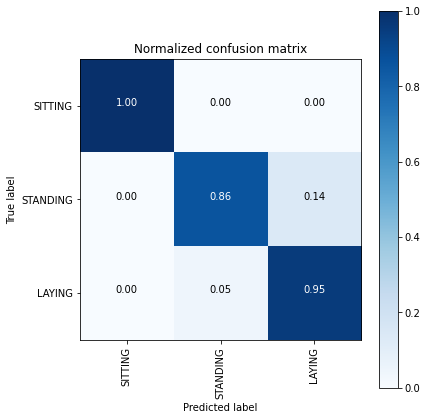

In [24]:
plt.figure(figsize=(6,6))
cm = confusion_matrix_cnn(y_test_st, model_st_1.predict(x_test_st),activites_stat)
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [20]:
model_st_1.save('/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/model_static_class.h5')

## Dynamic Classes Classification

In [25]:
dynamic_indices_train=np.where(y_train<=3)[0].tolist()
dynamic_indices_test=np.where(y_test<=3)[0].tolist()

In [26]:
x_train_dy=x_train[dynamic_indices_train]
x_test_dy=x_test[dynamic_indices_test]
y_train_dy=pd.get_dummies(y_train[dynamic_indices_train]).values
y_test_dy=pd.get_dummies(y_test[dynamic_indices_test]).values

In [27]:
print(y_train_dy.shape)
print(y_test_dy.shape)
print(x_test_dy.shape)
print(x_train_dy.shape)

(3285, 3)
(1387, 3)
(1387, 128, 9)
(3285, 128, 9)


In [28]:
model_dy = Sequential()
model_dy.add(Conv1D(64,5,activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model_dy.add(Conv1D(32,5,activation='relu',kernel_initializer='he_uniform'))
model_dy.add(Flatten())
model_dy.add(Dense(36,activation='softmax'))
model_dy.add(BatchNormalization())
model_dy.add(Dense(3,activation='softmax'))
model_dy.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dy.fit(x_train_dy,y_train_dy, epochs=40, batch_size=16,validation_data=(x_test_dy, y_test_dy),verbose=1)

Epoch 1/40
206/206 [==============================] - 1s 4ms/step - loss: 0.3498 - accuracy: 0.8734 - val_loss: 0.7135 - val_accuracy: 0.9553
Epoch 2/40
206/206 [==============================] - 1s 3ms/step - loss: 0.0351 - accuracy: 0.9921 - val_loss: 0.2379 - val_accuracy: 0.9589
Epoch 3/40
206/206 [==============================] - 1s 3ms/step - loss: 0.0304 - accuracy: 0.9921 - val_loss: 0.2304 - val_accuracy: 0.9373
Epoch 4/40
206/206 [==============================] - 1s 3ms/step - loss: 0.0099 - accuracy: 0.9985 - val_loss: 0.1064 - val_accuracy: 0.9676
Epoch 5/40
206/206 [==============================] - 1s 3ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.1246 - val_accuracy: 0.9654
Epoch 6/40
206/206 [==============================] - 1s 3ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1036 - val_accuracy: 0.9683
Epoch 7/40
206/206 [==============================] - 1s 4ms/step - loss: 9.5750e-04 - accuracy: 1.0000 - val_loss: 0.1699 - val_accuracy: 0.9618
Ep

In [29]:
score = model_dy.evaluate(x_test_dy, y_test_dy)

44/44 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 0.9913


In [30]:

from sklearn import metrics
activities_dyn = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
}


# Confusion Matrix
print(confusion_matrix_cnn(y_train_dy, model_dy.predict(x_train_dy),activities_dyn))

[[1226    0    0]
 [   0  986    0]
 [   0    0 1073]]


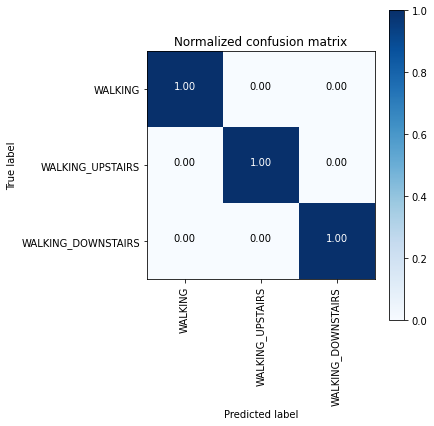

In [31]:
plt.figure(figsize=(6,6))
cm = confusion_matrix_cnn(y_train_dy, model_dy.predict(x_train_dy),activities_dyn)
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'], 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [32]:
model_dy.save('/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/model_dyn_class.h5')

## Final Prediction

In [33]:
from keras.models import load_model
import pickle
model_clf=load_model('/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/model_st_dy_clf.h5')
model_st_clf=load_model('/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/model_static_class.h5')
model_dy_clf=load_model('/content/drive/My Drive/Projects/LSTM_HUMAN/Human_Activity_Recognition/model_dyn_class.h5')


In [34]:
pred_clf_st_dy=model_clf.predict(x_test)

In [35]:
y_pred_clf_st_dy=np.argmax(pred_clf_st_dy,axis=1)


In [36]:
X_static=x_test[y_pred_clf_st_dy ==1]
X_dynamic = x_test[y_pred_clf_st_dy ==0]

In [37]:
pred_st=model_st_clf.predict(X_static)
pred_st=np.argmax(pred_st,axis=1)
pred_st=pred_st+4

In [38]:
pred_dy=model_dy_clf.predict(X_dynamic)
pred_dy=np.argmax(pred_dy,axis=1)
pred_dy=pred_dy+1

In [39]:
#appending final output to one list in the same sequence of input data
i,j = 0,0 
final_pred = []
for mask in y_pred_clf_st_dy:
    if mask == 1:
        final_pred.append(pred_st[i])
        i = i + 1
    else:
        final_pred.append(pred_dy[j])
        j = j + 1

In [40]:
##accuracy of test
from sklearn.metrics import accuracy_score
print('Accuracy of test data',accuracy_score(y_test,final_pred))

Accuracy of test data 0.9616559212758737


## Conclusion

* Acheived Greater than 96% Test Accuracy using Divide and Conquer Method